# Initialization

In [1]:
import os
import re
import json
import datetime as dt
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

### set experiment dates

In [2]:
date_start = dt.datetime.strptime("2005-01-01", "%Y-%m-%d")
date_end = dt.datetime.strptime("2018-06-30", "%Y-%m-%d") 
year_series = list(range(date_start.year, date_end.year)) 

### set root directories

In [3]:
dir_root = os.path.join('..')
dir_data_processing = os.path.join(dir_root, "data_processing")
dir_data_runs = os.path.join(dir_root, "data_runs")

### Set reports directories

In [4]:
dir_reports_ready =  os.path.join(dir_data_processing, "reports_ready_v1")

### set run prefix

In [5]:
run_prefix = "run_xx_xx"

### set flags

In [6]:
flag_debug = False

# Read data reports from files

In [7]:
def file2names(report_name):
    ticker_code, year_it = report.split("-")
    ticker, findex = ticker_code.split("_")
    year, it = year_it.split("_")
    
    return{
        "ticker_code": ticker_code,
        "ticker": ticker,
        "findex": findex,
        "year": int(year)
    }

In [8]:
def read_report(dir_name, file_name):
    file_path = os.path.join(dir_name, file_name)
    result = []
    with open(file_path, "r") as f_r:
        for text_line in f_r:
            result = result + text_line.strip().split(" ")
    return result        

In [9]:
document_names_list = []
document_words_list = []
amount_documents_in_series_dict = dict()

for year in year_series:
    amount_documents_in_series = 0
    #for every company read reports of a year
    for report in os.listdir(dir_reports_ready):
        names = file2names(report)
        if names["year"] == year:            
            amount_documents_in_series += 1
            document_words_list.append(read_report(dir_reports_ready, report))
            document_names_list.append(report)

    #keep track of documents in series
    amount_documents_in_series_dict[int(year)] = amount_documents_in_series
    print("Done on %s, number of documents: %s" % (year, amount_documents_in_series))


Done on 2005, number of documents: 233
Done on 2006, number of documents: 268
Done on 2007, number of documents: 275
Done on 2008, number of documents: 285
Done on 2009, number of documents: 303
Done on 2010, number of documents: 302
Done on 2011, number of documents: 304
Done on 2012, number of documents: 301
Done on 2013, number of documents: 320
Done on 2014, number of documents: 335
Done on 2015, number of documents: 382
Done on 2016, number of documents: 363
Done on 2017, number of documents: 368


# Corpus construction

In [10]:
import gensim
import gensim.corpora as corpora

## Create Dictionary

In [11]:
id2word = corpora.Dictionary(document_words_list)

## Create Corpus

In [12]:
texts = document_words_list
corpus = [id2word.doc2bow(text) for text in texts]

In [13]:
print("Number of unique tokens: %s" %len(id2word))

Number of unique tokens: 32277


view the first document as BOW

In [14]:
if flag_debug:
    print(corpus[:1])

# Find optimal topic number

In [15]:
from gensim.models import CoherenceModel

In [87]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3, passes=10):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=passes,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v_score = coherencemodel.get_coherence()
        coherence_values.append(c_v_score)
        
        perplexity = model.log_perplexity(corpus)
        perplexity_values.append(perplexity)
        
        print("Done on T: %s, c_v score: %s" % (num_topics, c_v_score))

    return model_list, coherence_values, perplexity_values

In [97]:
min_T = 5
max_T = 15
step_T = 1
passes_T = 10

In [98]:
model_list, coherence_values, perplexity_values = compute_coherence_values(
    dictionary=id2word, 
    corpus=corpus[:1 + amount_documents_in_series_dict[2005]], 
    texts=texts[:1 + amount_documents_in_series_dict[2005]], 
    start=min_T, 
    limit=max_T, 
    step=step_T,
    passes=passes_T)

Done on T: 5, c_v score: 0.3393005927362294
Done on T: 6, c_v score: 0.3269745943365736
Done on T: 7, c_v score: 0.3433038751636392
Done on T: 8, c_v score: 0.364044453712257
Done on T: 9, c_v score: 0.388138878722472
Done on T: 10, c_v score: 0.40182046568195207
Done on T: 11, c_v score: 0.349878368837302
Done on T: 12, c_v score: 0.3656987901642559
Done on T: 13, c_v score: 0.3937423571534192
Done on T: 14, c_v score: 0.37826417970577964
Done on T: 15, c_v score: 0.3954158511456158


In [99]:
import math
for i in range(len(coherence_values)):
    if math.isnan(coherence_values[i]):
        coherence_values[i] = 0

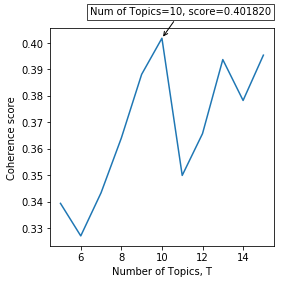

In [100]:
plt.figure(figsize=(4,4))

        
y = np.array(coherence_values)
x = np.array(range(min_T, max_T + 1, step_T))
plt.plot(x, y)    
    
    
xmax = x[np.argmax(y)]
ymax = y.max()
text = "Num of Topics=%s, score=%f" % (xmax, ymax)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
arrowprops=dict(arrowstyle="->")
kw = dict(xycoords='data',textcoords="axes fraction",
          arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
plt.annotate(text, xy=(xmax, ymax), xytext=(0.99,1.1), **kw)



plt.xlabel("Number of Topics, T")
plt.ylabel("Coherence score")

#pp = PdfPages(os.path.join(dir_topics, "cohearence_score.pdf"))

#plt.savefig(pp, format='pdf', bbox_inches='tight')
plt.show()

#pp.close() 
plt.close()

<Figure size 288x288 with 0 Axes>

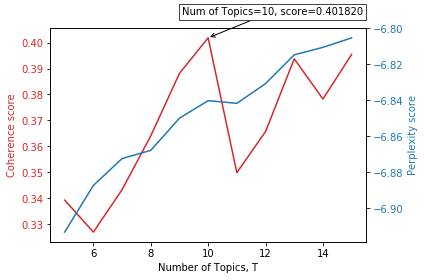

In [101]:
plt.figure(figsize=(4,4))

x = np.array(range(min_T, max_T + 1, step_T))
      
data1 = np.array(coherence_values)
data2 = np.array(perplexity_values)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Topics, T')
ax1.set_ylabel('Coherence score', color=color)
ax1.plot(x, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

xmax = x[np.argmax(data1)]
ymax = data1.max()
text = "Num of Topics=%s, score=%f" % (xmax, ymax)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
arrowprops = dict(arrowstyle="->")
kw = dict(xycoords='data',textcoords="axes fraction",
          arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
ax1.annotate(text, xy=(xmax, ymax), xytext=(0.99,1.1), **kw)

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Perplexity score', color=color)
ax2.plot(x, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.show()

In [102]:
best_model = model_list[0]
best_model

In [ ]:
for i in range(xmax):
    print([id2word.id2token[x[0]] for x in best_model.get_topic_terms(i, topn=10)])

# Run DTM with gensim wrapper

In [26]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import DtmModel

In [32]:
path_to_dtm_binary = "/Users/alan.spark/Project/cpp/dtm/dtm/main"

In [33]:
model = DtmModel(
    path_to_dtm_binary,
    corpus=corpus, #common_corpus, 
    id2word=id2word, #common_dictionary,
    num_topics = 15,
    time_slices=[amount_documents_in_series_dict[year] for year in sorted(amount_documents_in_series_dict.keys())]
)

In [41]:
model.show_topic(0, 0, topn=10)

[(0.014517799150706435, 'service'),
 (0.013770783151710486, 'billion'),
 (0.012440469405639464, 'revenue'),
 (0.012350483542043114, 'million'),
 (0.009719224435756358, 'include'),
 (0.009402882834558233, 'customer'),
 (0.009187265296174743, 'asset'),
 (0.008973599703777013, 'credit'),
 (0.00863934073289461, 'increase'),
 (0.00849840702111327, 'income')]

In [45]:
model.show_topic(4, 0, topn=10)

[(0.022874801151498127, 'risk'),
 (0.01677902998189779, 'bank'),
 (0.011939317138380477, 'group'),
 (0.011475389105176018, 'asset'),
 (0.010298602986486813, 'value'),
 (0.0100902991385062, 'credit'),
 (0.009923762053051316, 'daimlerchrysler'),
 (0.009625682689269777, 'market'),
 (0.009409823583647108, 'financial'),
 (0.009365617081009258, 'loan')]

# OLd stUff  do not run do not remove for now

In [ ]:
dict_term2id = {}
dict_id2term = {}

id_counter = 0
terms_list = sorted(terms_set)
for term in terms_list:
    dict_term2id[term] = id_counter
    dict_id2term[id_counter] = term
    id_counter += 1

## Define a function report vectorization

In [ ]:
def vectorize_report_dtm(file_report):
    vector_report = list()
    with open(file_report, 'r') as f_r:
        for text_line in f_r:
            term, tf = text_line.strip().split(',')
            if term in dict_term2id:
                vector_report.append("%s:%s" % (dict_term2id[term], tf))
    return vector_report

In [ ]:
def vectorize_report_test(file_report, dict_term2id_local, dict_id2term_local):
    local_term_id = 0
    vector_report = list()
    with open(file_report, 'r') as f_r:
        for text_line in f_r:
            term, tf = text_line.strip().split(',')
            if term in dict_term2id:
                if term not in dict_term2id_local:
                    dict_term2id_local[term] = local_term_id
                    dict_id2term_local[local_term_id] = term
                    local_term_id += 1
                vector_report.append((dict_term2id_local[term], int(tf)))
    return vector_report

# Build run data

### Read all reports (terms quantity map) for every ticker for every year in analysis

### create a run directory

In [9]:
dir_run = os.path.join(dir_data_runs, run_prefix)

In [10]:
if not os.path.exists(dir_run):
    os.makedirs(dir_run)

In [ ]:
amount_documents_in_series_dict = dict()
documents_name_list = list()
documents_vector_list = list()
for year in year_series:
    amount_documents_in_series = 0
    #for every company read reports of a year
    for ticker in sorted(tickers_fits_for_analysis):
        dir_ticker_reports = os.path.join(dir_reports, ticker)
        for report in os.listdir(dir_ticker_reports):
            if int(report[:4]) == year:
                #read a report
                amount_documents_in_series += 1
                documents_vector_list.append(vectorize_report_dtm(os.path.join(dir_ticker_reports, report)))
                documents_name_list.append(ticker + '-' + report)

    #keep track of documents in series
    amount_documents_in_series_dict[int(year)] = amount_documents_in_series

### write results into files

In [ ]:
#save prefix-seq.dat
with open(os.path.join(dir_run, run_prefix + '-seq.dat'), 'w') as f_w:
    f_w.write("%s\n" % len(year_series))
    for year in sorted(amount_documents_in_series_dict.keys()):
        f_w.write("%s\n" % amount_documents_in_series_dict[year])

In [ ]:
#save prefix-mult.dat, every document in SVM
with open(os.path.join(dir_run, run_prefix + '-mult.dat'), 'w') as f_w:
    for document in documents_vector_list:
        f_w.write("%s %s\n" % (len(document), ' '.join(document)))

In [ ]:
#save prefix-documents.dat, every document the same order with mult.dat
with open(os.path.join(dir_run, run_prefix + '-documents.dat'), 'w') as f_w:
    for document in documents_name_list:
        f_w.write("%s\n" % document)

In [ ]:
#save prefix-documents.dat, every document the same order with mult.dat
with open(os.path.join(dir_run, run_prefix + '-terms.dat'), 'w') as f_w:
    for term in terms_list:
        f_w.write("%s\n" % term)

### create result directories

In [ ]:
dir_results = os.path.join(dir_run, 'results')

if not os.path.exists(dir_results):
    os.makedirs(dir_results)

In [ ]:
dir_results = os.path.join(dir_run, 'interpretation')

if not os.path.exists(dir_results):
    os.makedirs(dir_results)